In [93]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold

from indoorplants.analysis import exploratory
from indoorplants.validation import crossvalidate, curves

from sklearn.metrics import accuracy_score, \
                            precision_score, \
                            recall_score, \
                            confusion_matrix, \
                            f1_score

In [70]:
%matplotlib inline

# `Ridge Regression`

### ------------------------------------------------------------------------------------------------

# Overview 

 **Goal**: predict the behavior of a continuous _endogenous_ variable given its corresponding _exogenous_ variables, under the constraint that we are penalizing based on coefficient magnitudes when solving for said coefficients. This setup allows for models that are less prone to over-fitting than simple OLS models are.
 
 **Model**: $y = X{\beta} + {\epsilon}$

**Terms**:
- $y$: vector of endogenous values
- $X$: matrix of exogenous values
- $\beta$: vector of coefficients for exogenous variables
- $\epsilon$: a representation of the random errors or fluctuations around the predicted line or plane

**Functionality**:
- $y$ is the result of taking the matrix product of $\beta$ and $X$
- i.e. each row in $y$ is the sum of the products, for that row, of each value of $X$ with its corresponding $\beta$

**Basic example**:
- *endogenous*: price of an apartment
- *exogenous*: square footage (1), number of rooms (2)
- $y = \beta_{0} + \beta_{1} * X_{1} + \beta_{2} * X_{2} + \epsilon$
- i.e. $constant + coefficient_{1} * area + coefficient_{2} * rooms$

### ------------------------------------------------------------------------------------------------

# Tikhonov regularization

$\displaystyle \min _{\beta }\,(\mathbf {y} -\mathbf {X} \beta )^{\mathsf {T}}(\mathbf {y} -\mathbf {X} \beta )+\lambda (\beta ^{\mathsf {T}}\beta -c)$

$\displaystyle {\hat {\beta }}_{R}=(\mathbf {X} ^{\mathsf {T}}\mathbf {X} +\lambda \mathbf {I} )^{-1}\mathbf {X} ^{\mathsf {T}}\mathbf {y}$

### ------------------------------------------------------------------------------------------------

# Parameter Estimation - OLS

**Goal**: given $X$ and $y$, find $\beta$

**Method**: there exist many ways to reach our goal - we will start with Ordinary Least Squares (OLS)

(notes written with support from [Wikipedia](https://en.wikipedia.org/wiki/Ordinary_least_squares) and [ESL](http://web.stanford.edu/~hastie/ElemStatLearn/))

### Background

- to measure the distance between a response and a predicted response, one can take the difference between the two values
- this would be written as, for the $i^{th}$ data point, $y_{i} - {X_{i}}\beta$ (note that $X_{i}$ is a row of $X$), and is referred to as the _residual_ for this data point

### Overall model fit

- summing the squares of all residuals provides a measure of overall model fit
- sum of squared residuals: $\sum_{i=1}^{n}(y_{i} - \sum_{j=1}^{p}{X_{i, j}\beta_{j})}^{2} = {(y-X\beta)}^{T}(y-X\beta)$

### Estimate Beta

- if we find the values of $\beta$ that minimize the sum of the squared residuals, we have found the model coefficients that provide the best fit
- to find the values of $\beta$ that minimize ${(y-X\beta)}^{T}(y-X\beta)$ we need to first differentiate with respect to $\beta$, yielding a first derivative $-2X^{T}(y - X\beta)$
- if we set that first derivate equal to 0, $X^{T}(y - X\beta) = 0$, we can, making some assumptions, solve to:

$$\hat\beta = (X^{T}X)^{-1}X^{T}y$$

- see more on the derivation of OLS regression [here](https://are.berkeley.edu/courses/EEP118/current/derive_ols.pdf)

### Evaluation

- a commonly used metric for fit assessment is that of $R^{2}$
- this is the ratio of the variance of $\hat{y}$ around the mean of $y$, $\bar{y}$, to the variance of $y$, i.e. the ratio of "explained" to "total" variance of $y$
- which is written as $\large\frac{\sum(\hat{y} - \bar{y})^{2}}{\sum(y - \bar{y})^{2}}$
- useful use of this metric requires the model to include a constant, or $\beta_{0}$, term, in which case 0 < $R^{2}$ < 1, with closer to 1 being better

### ------------------------------------------------------------------------------------------------

# Implementation

In [4]:
class RidgeRegressor:
    """Ridge Regression class, built for NumPy arrays. 
    Fits using lin alg. Always supplies a constant coefficient.
    Very unstable!
    
    (subbing in `alpha` for `lambda` due to the latter's protected status)
    """
    
    def __init__(self, alpha=1):
        self.X = None
        self.y = None
        self.B = None
        self.alpha = alpha
        self.y_hat = None
        
    
    def fit(self, X, y):
        for_coeff = np.ones((X.shape[0], 1))
        X = np.hstack((X, for_coeff))

        self.B = np.linalg.inv(X.T.dot(X) + self.alpha * np.identity(X.shape[1])).dot(X.T).dot(y)
        self.X = X
        self.y = y
    
    
    def predict(self, X):
        if self.B is None:
            return None
        self.y_hat = self.X.dot(self.B)
        return self.y_hat

    
    def r_sqrd(self):
        if self.y is None:
            return None
        elif self.y_hat is None:
            y_hat = self.predict()
            
        y_bar = np.mean(self.y)
        explained = np.sum(np.power(self.y_hat - y_bar, 2))
        total = np.sum(np.power(self.y - y_bar, 2))
        return explained / total

### ------------------------------------------------------------------------------------------------

# Testing

### Generate Fake Data

- with `Ridge`, we are looking to prevent overfitting
- overfitting can happen when a model is too tightly coupled to the sample of the data that it happens to be trained on
- so, to do this right, we need an idea of what the distribution of our population looks like
- then, we need to draw sub-samples that do not represent the population very well

In [5]:
X = np.array([[np.random.normal(loc=_, scale=(_ + 1)) for _ in range(100)] for _ in range(3)])

In [6]:
X = X.T

In [7]:
y = np.array([np.random.normal() for _ in range(100)])

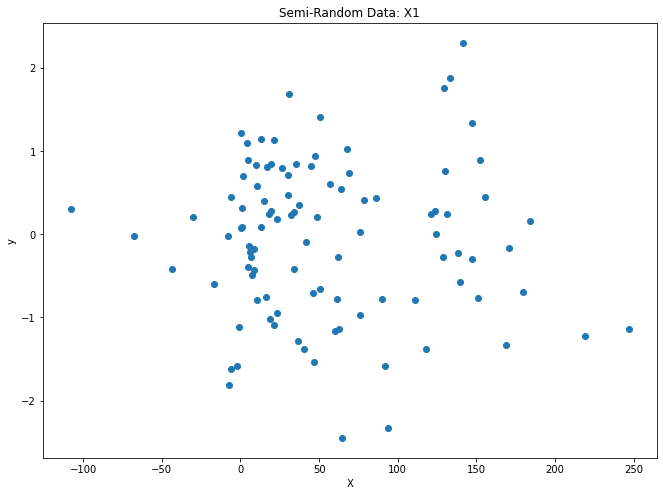

In [8]:
plt.figure(figsize=(11, 8))
ax = plt.scatter(X[:, 0], y)
plt.xlabel("X")
plt.ylabel("y")
t = plt.title("Semi-Random Data: X1")

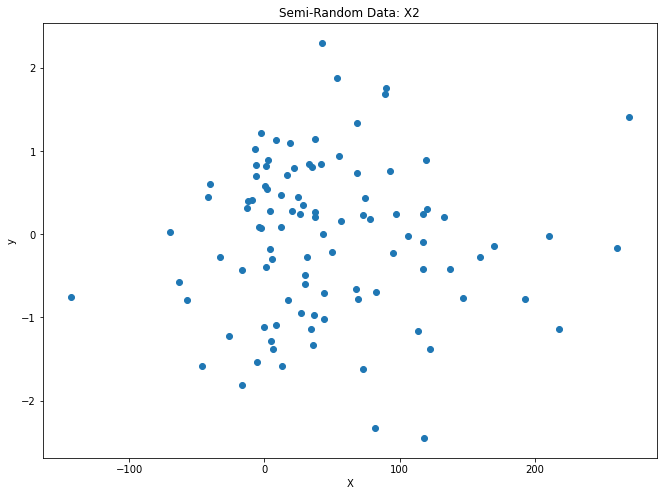

In [9]:
plt.figure(figsize=(11, 8))
ax = plt.scatter(X[:, 1], y)
plt.xlabel("X")
plt.ylabel("y")
t = plt.title("Semi-Random Data: X2")

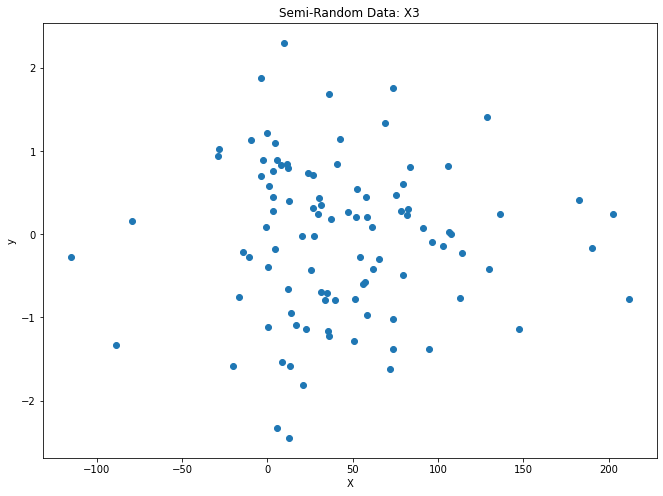

In [10]:
plt.figure(figsize=(11, 8))
ax = plt.scatter(X[:, 2], y)
plt.xlabel("X")
plt.ylabel("y")
t = plt.title("Semi-Random Data: X3")

In [11]:
np.linalg.inv(X.T.dot(X) + np.identity(X.shape[1])).dot(X.T).dot(y)

array([-0.00077049,  0.00032345, -0.00042096])

In [12]:
ridge = RidgeRegressor()

In [13]:
ridge.fit(X, y)

In [14]:
y_hat = ridge.predict(X)

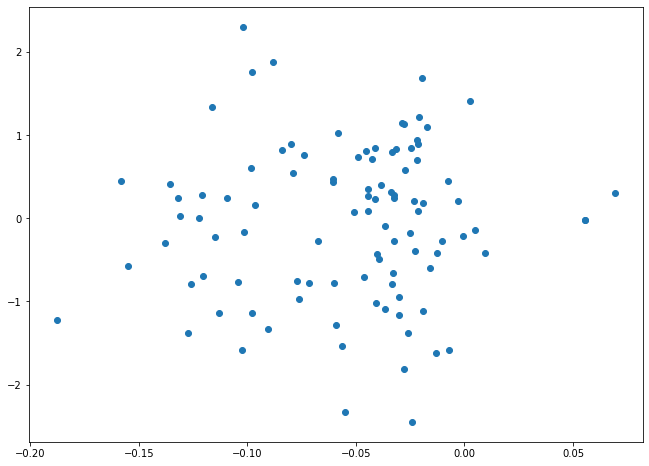

In [15]:
plt.figure(figsize=(11, 8))
ax = plt.scatter(y_hat, y)

In [16]:
ridge.r_sqrd()

0.0025305368169958654

## Testing on sklearn ridge regression

In [17]:
clf = Ridge(alpha=1.0)
clf.fit(X, y)

Ridge()

In [18]:
y_hat2 = clf.predict(X)

In [19]:
clf.score(X,y)

0.0025148001178153523

In [20]:
(y_hat - y_hat2).sum()

0.019736382704900586

## Testing on real data
- Insurance data can be find [here](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv)
- Independent variables: `age`, `sex`, `bmi`, `children`,`smoker`,`region`
- Dependent variables: `charges`

In [47]:
url ="https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"

In [48]:
insurance_data = pd.read_csv(url)

In [49]:
insurance_data.shape

(1338, 7)

In [50]:
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 1 Cleaning

In [25]:
insurance_data.duplicated().sum()

1

In [26]:
insurance_data = insurance_data.drop_duplicates()

In [27]:
insurance_data.duplicated().sum()

0

In [71]:
insurance_data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [28]:
insurance_data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### 2. Exploratory Data Analysis
#### 2.1 Age

In [76]:
insurance_data.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

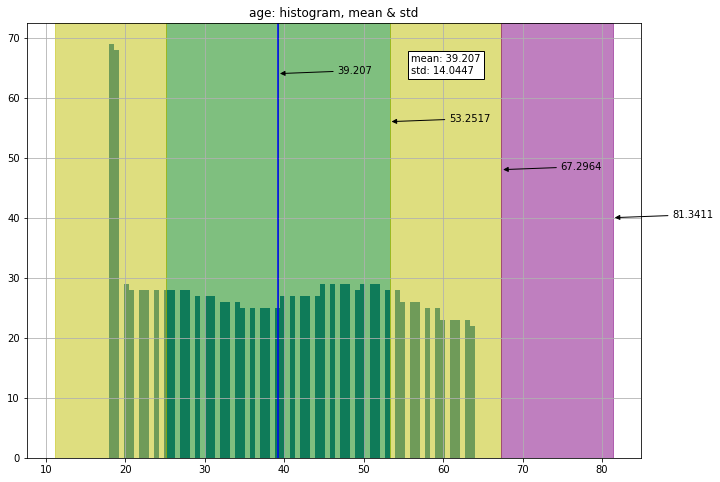

In [54]:
ax = exploratory.center_scale_plot(insurance_data.age, np.mean, np.std, bins=73)

**Notes:** The age in the insurance data range from 18 to 64.  The average age of the data set is 39.2. 

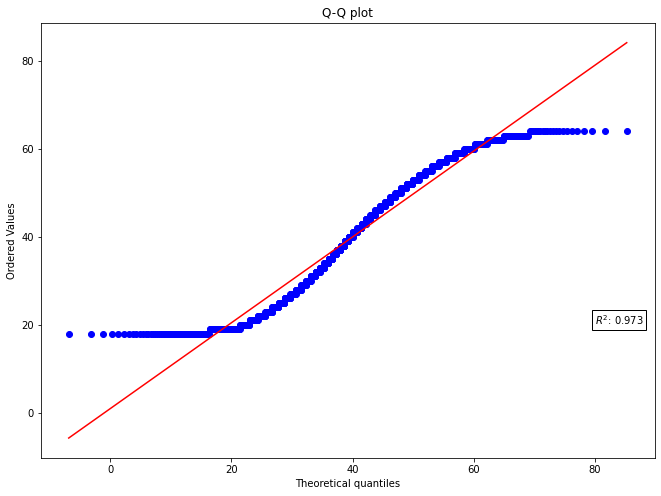

In [67]:
ax = exploratory.qq_plot(insurance_data.age)

**Notes:** The Q-Q plot shows that the age data is partially close to a normal distribution (quantile 20 to 60). However on both tiles. there are sharpe drops because the range of data are from 18 to 64.

#### 2.2 Sex

In [56]:
insurance_data.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

**Notes:** Male and female are equally distributed

#### 2.3 bmi

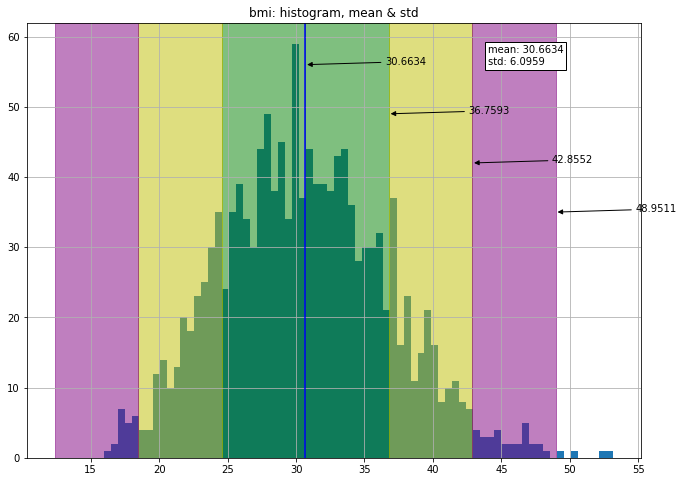

In [58]:
ax = exploratory.center_scale_plot(insurance_data.bmi, np.mean, np.std, bins=73)

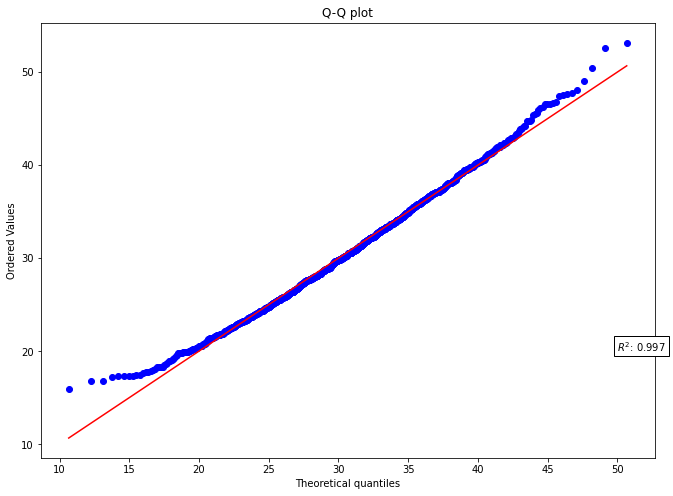

In [66]:
ax = exploratory.qq_plot(insurance_data.bmi)

**Notes:** 
- `bmi` is a measure of body fat based on height and weight that applies to adult men and women.
- The distribution of bmi is very similar to a normal distribution with a slightly skewness to the right

#### 2.4 Children

In [60]:
insurance_data.children.value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

#### 2.5 smoker

In [61]:
insurance_data.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

#### 2.6 region

In [62]:
insurance_data.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

#### 2.7 charge

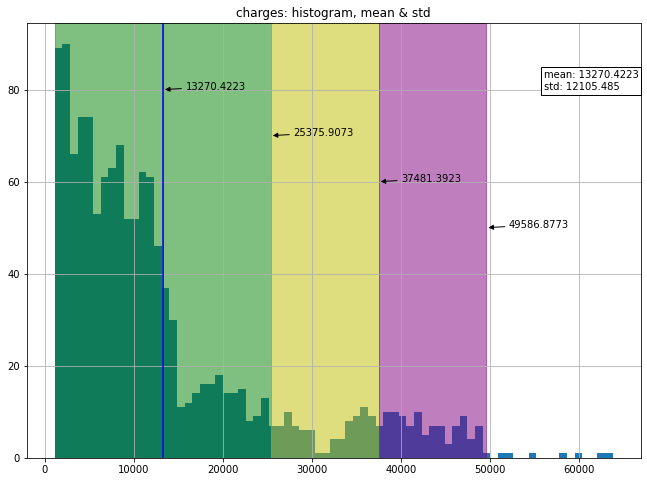

In [64]:
ax = exploratory.center_scale_plot(insurance_data.charges, np.mean, np.std, bins=73)

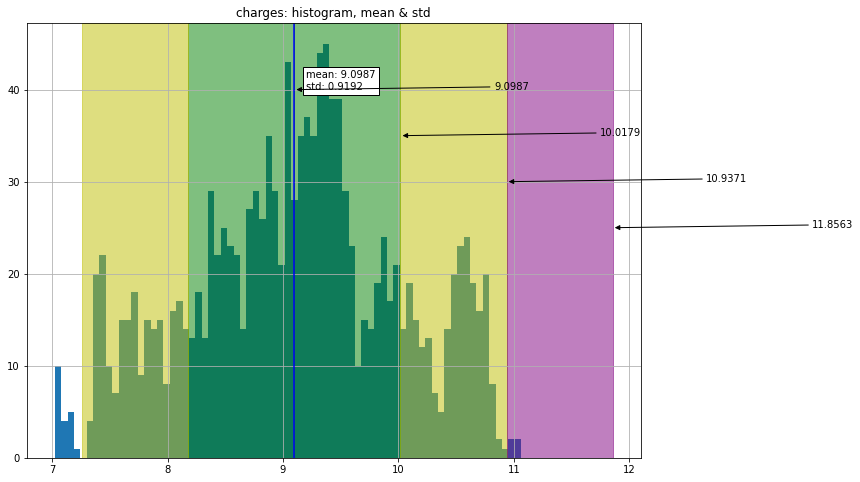

In [65]:
ax = exploratory.center_scale_plot(np.log(insurance_data.charges), np.mean, np.std, bins=73)


**Notes**
Taking the log transform has yielded a more symmetrical dataset that sits almost entirely within 3 standard deviation bands.

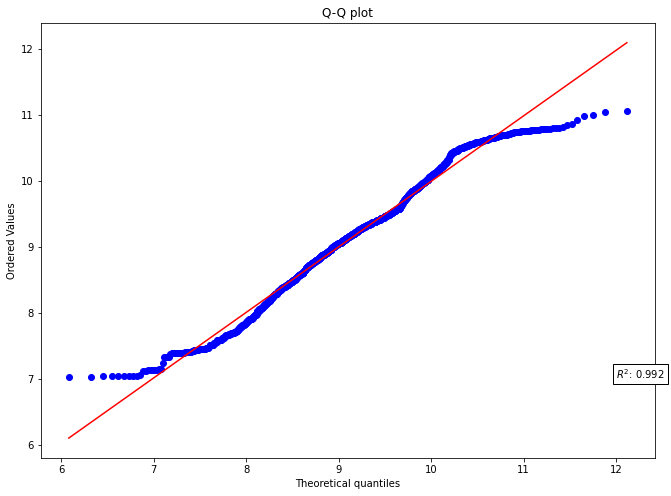

In [68]:
ax = exploratory.qq_plot(np.log(insurance_data.charges))

### 2. One hot encoding

In [83]:
def get_modeling_df(one_hot_cols, df):
    one_hot_df = []
    for col in one_hot_cols:
        temp = pd.get_dummies(df[col],prefix="is_{}".format(col),drop_first=True)
        one_hot_df.append(temp)
    one_hot_df = pd.concat(one_hot_df,axis=1)
    return pd.concat([df.drop(columns=one_hot_cols),one_hot_df], axis=1)

In [84]:
one_hot_cols = ['sex','smoker','region']
insurance_for_modeling = get_modeling_df(one_hot_cols, insurance_data)

In [86]:
insurance_for_modeling.dtypes

age                      int64
bmi                    float64
children                 int64
charges                float64
is_sex_male              uint8
is_smoker_yes            uint8
is_region_northwest      uint8
is_region_southeast      uint8
is_region_southwest      uint8
dtype: object

### 3. Collinearity test

In [85]:
insurance_for_modeling.corr().style.background_gradient(cmap='coolwarm')

,age,bmi,children,charges,is_sex_male,is_smoker_yes,is_region_northwest,is_region_southeast,is_region_southwest
age,1.000000,0.109272,0.042469,0.299008,-0.020856,-0.025019,-0.000407,-0.011642,0.010016
bmi,0.109272,1.000000,0.012759,0.198341,0.046371,0.003750,-0.135996,0.270025,-0.006205
children,0.042469,0.012759,1.000000,0.067998,0.017163,0.007673,0.024806,-0.023066,0.021914
charges,0.299008,0.198341,0.067998,1.000000,0.057292,0.787251,-0.039905,0.073982,-0.043210
is_sex_male,-0.020856,0.046371,0.017163,0.057292,1.000000,0.076185,-0.011156,0.017117,-0.004184
is_smoker_yes,-0.025019,0.003750,0.007673,0.787251,0.076185,1.000000,-0.036945,0.068498,-0.036945
is_region_northwest,-0.000407,-0.135996,0.024806,-0.039905,-0.011156,-0.036945,1.000000,-0.346265,-0.320829
is_region_southeast,-0.011642,0.270025,-0.023066,0.073982,0.017117,0.068498,-0.346265,1.000000,-0.346265
is_region_southwest,0.010016,-0.006205,0.021914,-0.043210,-0.004184,-0.036945,-0.320829,-0.346265,1.000000


### 4. Modeling - Ridge

In [88]:
X = insurance_for_modeling[[i for i in insurance_for_modeling.columns if 'charges' not in i]]

In [89]:
y = insurance_for_modeling.charges

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [91]:
X_train.shape

(1070, 8)

In [70]:
def get_r_sqrd(alpha,X_train,y_train,y_test):
    ridge = RidgeRegressor(alpha)
    ridge.fit(X_train, y_train)
    y_hat = ridge.predict(y_test)
    return ridge.r_sqrd()

In [71]:
get_r_sqrd(1,X_train,y_train,y_test)

0.7455531306730392

In [72]:
alpha_l = np.linspace(0.01,50,50)

In [73]:
rsq_l = [get_r_sqrd(i,X_train,y_train,y_test) for i in alpha_l]

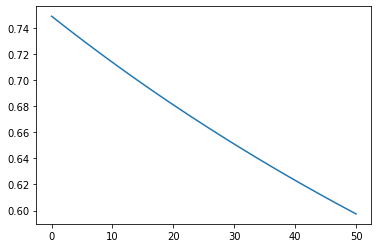

In [74]:
plt.plot(alpha_l,rsq_l)

### With corss validation

In [77]:
def get_r_sqrd_kfolds(alpha, n_splits):
    kf = KFold(n_splits)
    r_sqrd_l = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        r_sqrd_l.append(get_r_sqrd(alpha,X_train,y_train,y_test))
    return r_sqrd_l

In [86]:
alpha_l = np.linspace(0.01,50,50)

In [100]:
var_l = []
mean_l = []
for i in alpha_l:
    var_l.append(np.var(get_r_sqrd_kfolds(alpha=i, n_splits=10)))
    mean_l.append(np.mean(get_r_sqrd_kfolds(alpha=i, n_splits=10)))

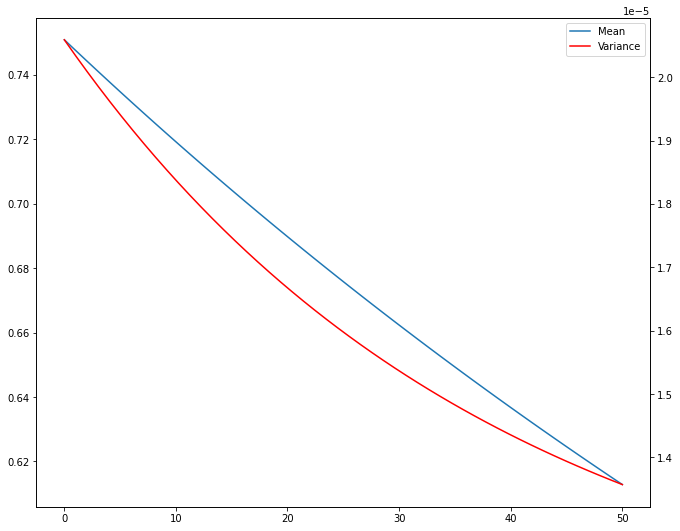

In [107]:
fig, ax = plt.subplots(figsize =(11,9))
ax.plot(alpha_l, mean_l, label="Mean")
ax2 = ax.twinx()
ax2.plot(alpha_l, var_l, color = 'red', label="Variance")

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc=1)